In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.patches as mpatches


In [2]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

### Loading Datasets

In [3]:
india_map= gpd.read_file("India Map\India Map 2020\india_administrative_state_boundary.shp")
master_data=pd.read_csv("master data\master_data.csv")
gdp_current=pd.read_csv("GSDP current.csv").dropna(how="all")
gdp_constant=pd.read_csv("GSDP constant.csv")
population=pd.read_csv("population.csv")
state_abb=pd.read_csv("state_abb.csv")

state_abb.State=state_abb.State.str.upper()
state_abb.State=state_abb.State.str.replace(" AND ", " & ")

population["State"]=population.State.str.upper()
gdp_current["State\\UT"]=gdp_current["State\\UT"].str.upper()
gdp_constant["State\\UT"]=gdp_constant["State\\UT"].str.upper()

In [4]:
master_data["State_project"]=master_data.State_project.str.upper()
master_data.State_project= master_data.State_project.str.replace(" AND ", " & ")
master_data["State_company"]=master_data.State_company.str.upper()
master_data["State_company"]=master_data.State_company.str.replace(" AND ", " & ")
master_data["State_company"]=master_data["State_company"].str.replace( 'ORISSA', 'ODISHA')

data = master_data.loc[:, ["Project Amount Outlay", "Amount Spent", "State_project"]].groupby("State_project").agg("sum").drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])


data=data.merge(population, left_on="State_project", right_on="State")
data["Project Amount Outlay per capita"] =data["Project Amount Outlay"]/data["population"]
data["Amount Spent per capita"]=data["Amount Spent"]/ data["population"]

In [5]:
india_map.st_nm=india_map.st_nm.str.upper()
india_map=india_map.merge(data, left_on="st_nm", right_on="State")

gdp_current = gdp_current.iloc[:,:-2].melt(id_vars="State\\UT", var_name="year", value_name="gdp")
gdp_constant = gdp_constant.iloc[:,:-2].melt(id_vars="State\\UT", var_name="year", value_name="gdp")

gdp_current["State\\UT"] = gdp_current["State\\UT"].replace("ANDHRA PRADESH ",'ANDHRA PRADESH')
gdp_constant["State\\UT"] = gdp_constant["State\\UT"].replace("ANDHRA PRADESH ",'ANDHRA PRADESH')

### Analyzing CSR Spending

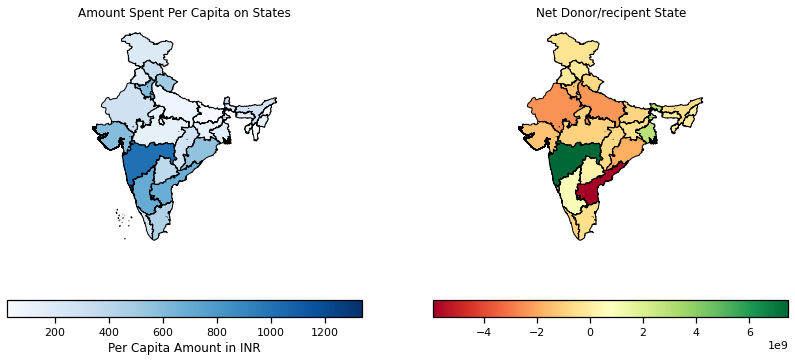

In [6]:

fig, (ax, ax2)= plt.subplots(ncols=2, figsize=(14,6))


india_map.plot(column="Amount Spent per capita", ax=ax, legend=True, edgecolor="black", cmap='Blues', 
               legend_kwds={'orientation': "horizontal", "label":"Per Capita Amount in INR"})
ax.set_title("Amount Spent Per Capita on States" )
ax.set_axis_off()

#net amount
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_project"]!="PAN INDIA"]
data=data[data["State_company"] !=np.nan]

data=data[data["State_project"]!=data["State_company"]]

recived=data.groupby(["State_project", "year"])["Amount Spent"].agg('sum').sort_values(ascending=False)
recived=recived.groupby("State_project").agg("mean")

given=data.groupby(["State_company", "year"])["Amount Spent"].agg("sum").sort_values(ascending=False)
given=given.groupby("State_company").agg("mean")

net=(given - recived).sort_values(ascending=False)

india_map=india_map.merge(pd.DataFrame(net).reset_index().rename(columns={"Amount Spent":"net"}), left_on="st_nm", right_on="index")



ax2=india_map.plot("net", ax=ax2, legend=True, edgecolor="black", cmap='RdYlGn',
                   legend_kwds={'orientation': "horizontal", "label":""})

ax2.set_title("Net Donor/recipent State" )
ax2.set_axis_off()


### Gini Coefficient for GSDP and CSR

In [7]:
def gini(array):
    #credit: 
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))    
    
for year in master_data["year"].unique():
    
    gdp=gdp_current[gdp_current["year"]==year]

    csr_spent=master_data[master_data["year"]==year].groupby("State_project")["Amount Spent"].agg("sum")

    gdp=gdp.merge(csr_spent, left_on="State\\UT", right_on="State_project")

    gdp=gdp.merge(population, left_on="State\\UT", right_on="State")

    gdp=gdp.merge(state_abb, left_on="State\\UT", right_on="State")

    gdp["gdp_pc"]=gdp["gdp"]/gdp["population"]
    gdp["csr_pc"]=gdp["Amount Spent"]/gdp["population"]


    print(year,":",gini(gdp["gdp_pc"].values), "\t",  gini(gdp["csr_pc"].values), end="\n\n")





2014-15 : 0.28216605837827763 	 0.4805642203609851

2015-16 : 0.2903071554648819 	 0.4794028646251985

2016-17 : 0.2914435137809126 	 0.47844807107607285

2017-18 : 0.2942536552305964 	 0.541729167562968

2018-19 : 0.2890889327342525 	 0.4387422076947665



### Relationship between CSR and GDP

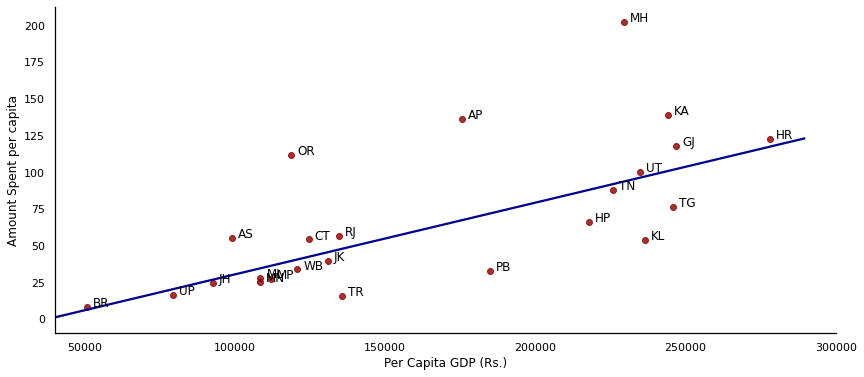

In [8]:

#{paper, notebook, talk, poster}
sns.set_context("notebook")
data = master_data.loc[:, ["Project Amount Outlay", "Amount Spent", "State_project", "year"]].groupby(["State_project", "year"]).agg("sum").drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])

data =data.reset_index()


data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent per capita"]= data["Amount Spent"]/data["population"]
data["Project Amount Outlay per capita"]= data["Project Amount Outlay"]/data["population"]

data=data[data["population"]>2500000]


data=data.groupby("State_project").agg({"Project Amount Outlay":"mean", "Amount Spent per capita":"mean", "gdp per capita":"max"})

fig,ax=plt.subplots(figsize=(14,6))

d=data.drop(["DELHI"])
d=d.merge(state_abb, left_on="State_project", right_on="State")

ax=sns.regplot(data=d, y="Amount Spent per capita", x="gdp per capita", order=1, ci=0, ax=ax, truncate=False, robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})
ax.set_xlim((40000,300000))

sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(d.abb):
    ax.annotate(txt, (d["gdp per capita"][i]+2000, d["Amount Spent per capita"][i]))

### CSR Received from Corporates with the state and outside the state

Text(0.5, 1.0, 'Per capita Amount spent by Corporates outside the State')

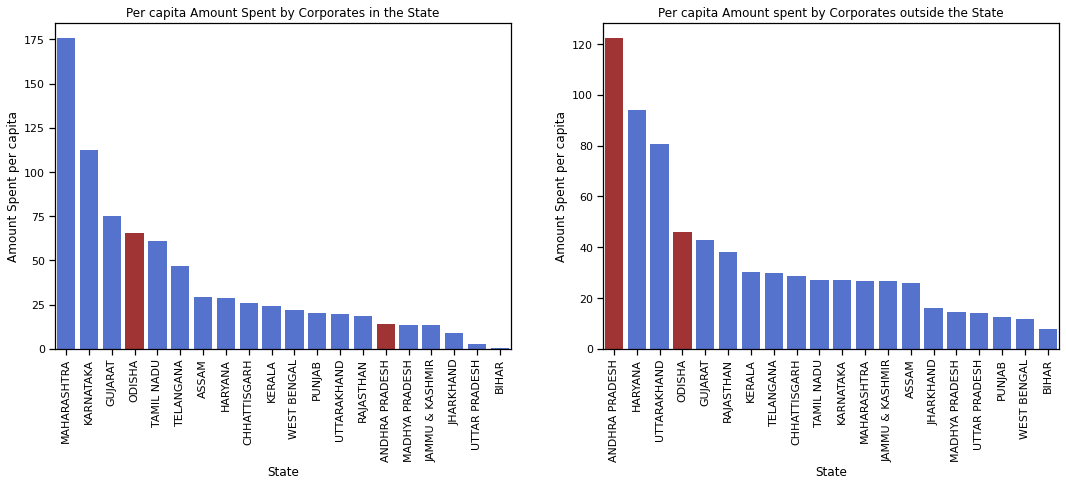

In [9]:
fig, (ax1,ax2) =plt.subplots(ncols=2, figsize=(18, 6))

st=["ANDHRA PRADESH", "ODISHA"]
#Calculating amount recived from companies within the state
data = master_data[master_data["State_project"]==master_data["State_company"]]

data=data.groupby(["State_project", "year"])["Amount Spent"].agg("sum")
data=data.groupby("State_project").agg("mean").sort_values(ascending=False)
data

data=population.merge(data, left_on="State", right_on="State_project")
data=data[data["population"]>10000000]

data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]

local_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=local_spent[~ local_spent["State"].isin(["DELHI","GOA","LAKSHADWEEP", "ARUNACHAL PRADESH","SIKKIM","CHANDIGARH", "PUDUCHERRY",])]

palette=["royalblue" if x not in st else 'firebrick' for x in data.State]

ax1 = sns.barplot(data=data, y="Amount Spent per capita", x="State", ax=ax1, palette=palette)
ax1.set_xticklabels(data.State,rotation=90)
ax1.set_title("Per capita Amount Spent by Corporates in the State")
#ax1.yaxis.grid()

#calculating amount recived from outside the state
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.groupby(["State_project", "year"])["Amount Spent"].agg("sum")
data=data.groupby("State_project").agg("mean").sort_values(ascending=False)

data=population.merge(data, left_on="State", right_on="State_project")
data=data[data["population"]>10000000]

data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]
nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=nonlocal_spent[~ nonlocal_spent["State"].isin(["DELHI","GOA", "LAKSHADWEEP"])]

nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=nonlocal_spent[~ nonlocal_spent["State"].isin(["DELHI","GOA", "LAKSHADWEEP", "SIKKIM","CHANDIGARH", "PUDUCHERRY", "ARUNACHAL PRADESH"])]

palette=["royalblue" if x not in st else 'firebrick' for x in data.State]

ax2 = sns.barplot(data=data, y="Amount Spent per capita", x="State", ax=ax2, palette=palette)
#ax2.yaxis.grid()
plt.xticks(rotation=90)
plt.title("Per capita Amount spent by Corporates outside the State")

### Trend of funds received from corporates within state and corporates outside the States:

Text(0, 0.5, 'Per Capita Amount Spent')

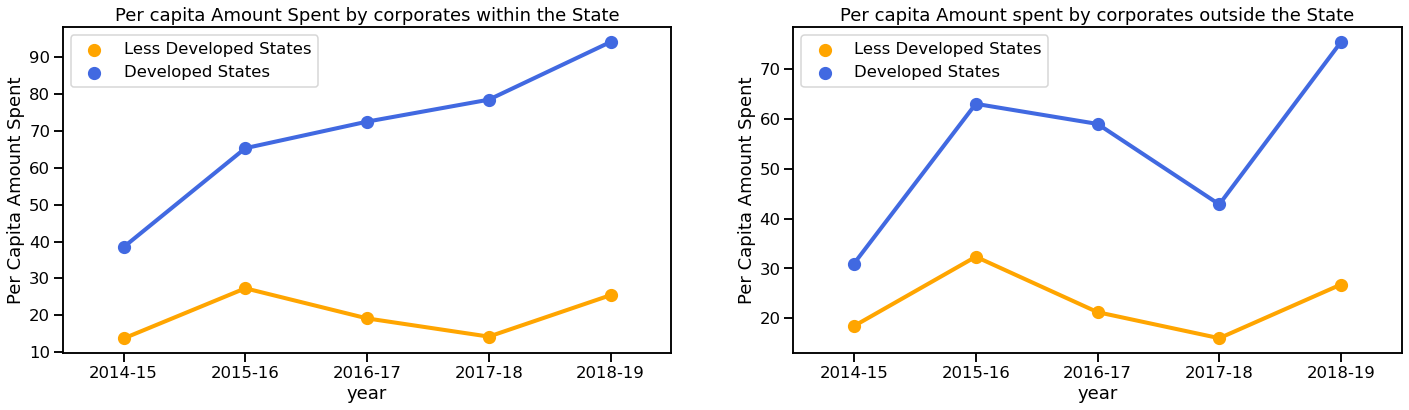

In [10]:
#{paper, notebook, talk, poster}
sns.set_context("talk")

fig,(ax, ax2)=plt.subplots(ncols=2, figsize=(24, 6))

#Trend of Per capita Amount from companies with the States
data = master_data[master_data["State_project"]==master_data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]

data['status'] = np.where((data['gdp per capita']>150000) , 1, 0)


data=data.groupby([ "State_project","year"])[["Amount Spent", "status"]].agg({"Amount Spent":"sum", "status":"mean"})

x=data.reset_index().groupby("State_project")["status"].agg("max")
data=data.reset_index().drop("status", axis=1).merge(x, on="State_project").set_index(["State_project", "year"])

ax = sns.pointplot(data=data.reset_index(),x="year", y="Amount Spent",hue="status",palette=[ "orange","royalblue"], ci=0, ax=ax, legend=True, )
leg_handles = ax.get_legend_handles_labels()[0]

ax.legend(leg_handles, ['Less Developed States', 'Developed States'])

ax.set_title("Per capita Amount Spent by corporates within the State")
ax.set_ylabel("Per Capita Amount Spent")

#Trend of States recived from companies outside the States

data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]


data['status'] = np.where((data['gdp per capita']>150000) , 1, 0)


data=data.groupby([ "State_project","year"])[["Amount Spent", "status"]].agg({"Amount Spent":"sum", "status":"max"})
x=data.reset_index().groupby("State_project")["status"].agg("max")
data=data.reset_index().drop("status", axis=1).merge(x, on="State_project").set_index(["State_project", "year"])

ax2 = sns.pointplot(data=data.reset_index(),x="year", y="Amount Spent",hue="status",palette=[ "orange","royalblue"], ci=0, ax=ax2, legend=True, )
leg_handles = ax2.get_legend_handles_labels()[0]

ax2.legend(leg_handles, ['Less Developed States', 'Developed States'])
ax2.set_title("Per capita Amount spent by corporates outside the State")
ax2.set_ylabel("Per Capita Amount Spent")

### Proportion of Amount Spent corporates within the State:
    - If the proportion is 1 (see chart below), then the corporates within the states are spending all of their money within the state
    - If the proportion is 0, then the corporates within the states are spending all of their money on other states

In [11]:
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_project"]!="PAN INDIA"]
data=data[data["State_company"] !=np.nan]

data=data[data["State_project"]!=data["State_company"]]

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]


given=data.groupby(["State_company", "year"])["Amount Spent"].agg("sum")#.sort_values(ascending=False)
#given=given.groupby("State_company").agg("mean")


#Trend of Per capita Amount from companies with the States
data = master_data[master_data["State_project"]==master_data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]

within=data.groupby([ "State_project","year"])["Amount Spent"].agg("sum")



Text(0, 0.5, 'Proportion of Amount Spent within the State')

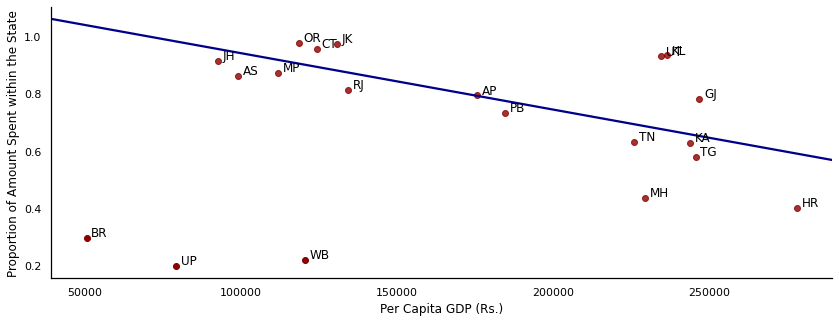

In [12]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

within.index=within.index.rename(("State_company","year"))

p=within/(given+within)

p=pd.DataFrame(p)
p=p.merge(gdp_current, left_on=["State_company", "year"], right_on=['State\\UT', "year"])

p= p.merge(population, left_on="State\\UT", right_on="State")
l=p
p=p.groupby("State\\UT").agg({"Amount Spent":"mean", "population":"mean", "gdp":"max"})

p["gdp"]=(p["gdp"]/p["population"])*10000000

fig,ax=plt.subplots(figsize=(14,5))


p=p.merge(state_abb, left_on="State\\UT", right_on="State")
p=p[~ p["Amount Spent"].isna()]
p=p[p["State"]!="DELHI"]

k=p[p["Amount Spent"]<0.4]
k=k.reset_index()
p=p[p["Amount Spent"]>0.35]
p=p.reset_index()


ax.plot(k["gdp"], k["Amount Spent"], "o", color="darkred")
ax=sns.regplot(data=p, y="Amount Spent", x="gdp", order=1, ci=0, ax=ax, truncate=False, #robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})


sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(p.abb):
    ax.annotate(txt, (p["gdp"][i]+1500, p["Amount Spent"][i]+0.005))
 
for i, txt in enumerate(k.abb):
    ax.annotate(txt, (k["gdp"][i]+1500, k["Amount Spent"][i]+0.005))

plt.ylabel("Proportion of Amount Spent within the State")



$$p =\frac{\text{Money Spent on the State by the companies in the state}}{\text{Total Amount Spent by the Companies in the State}}$$



Text(0, 0.5, 'Per Capita Amount (Rs.)')

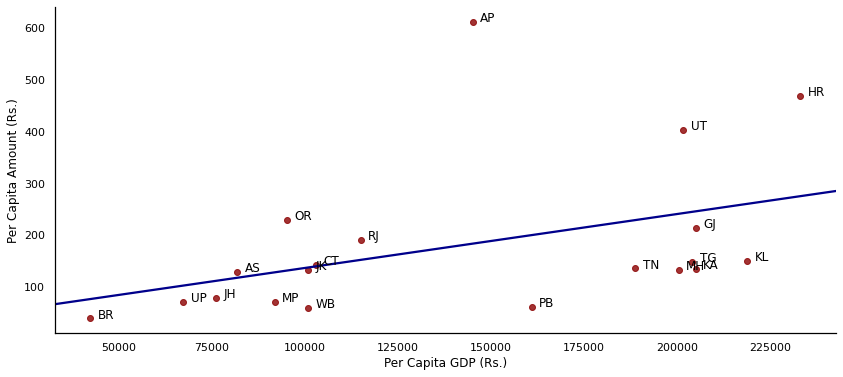

In [13]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

fig,ax=plt.subplots(figsize=(14,6))

data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]

data=data.groupby([ "State_project"])[["Amount Spent per capita", "gdp per capita"]].agg({"Amount Spent per capita":"sum", "gdp per capita":"mean"})


d=data.drop(["DELHI"])
d=d.merge(state_abb, left_on="State_project", right_on="State")

ax=sns.regplot(data=d, y="Amount Spent per capita", x="gdp per capita", order=1, ci=0, ax=ax, truncate=False, #robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})


sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(d.abb):
    ax.annotate(txt, (d["gdp per capita"][i]+2000, d["Amount Spent per capita"][i]))

ax.set_ylabel("Per Capita Amount (Rs.)")

### 

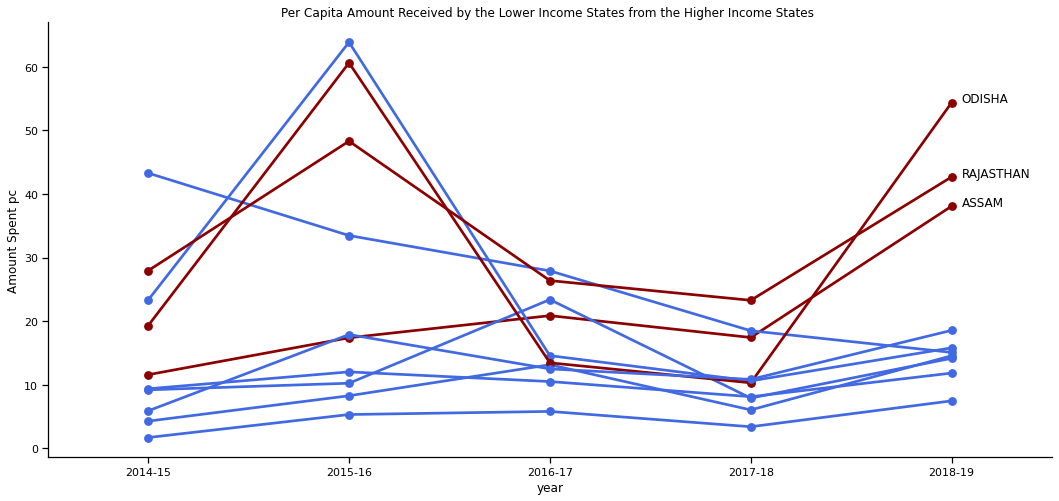

In [14]:
x=gdp_current[(gdp_current.year=="2018-19")]
x=x.merge(population, left_on="State\\UT", right_on="State")
x["gdp per capita"]=(x["gdp"]/x["population"])*10000000

rich_states = list(x[(x["gdp per capita"]>150000) & (x["population"]>10000000)]["State\\UT"])

poor_states= list(x[(x["gdp per capita"]<150000) & (x["population"]>10000000)]["State\\UT"])


flow=master_data[(master_data.State_project.isin(poor_states)) & (master_data.State_company.isin(rich_states))]


flow=flow.groupby(["year", "State_project"])["Amount Spent"].agg("sum")
flow=flow.reset_index()

flow=flow.merge(population, left_on="State_project", right_on="State")
flow["Amount Spent pc"]=flow["Amount Spent"]/flow["population"]

fig, ax=plt.subplots(figsize=(18,8))
palette=["darkred","royalblue","royalblue","royalblue","royalblue","royalblue","darkred", "darkred","royalblue", "royalblue"]
sns.pointplot(y=flow["Amount Spent pc"], x=flow.year, hue=flow.State_project, palette=palette)#

flow_19=flow[flow["year"]=="2018-19"]

flow=flow[flow.State_project.isin(["ODISHA", "RAJASTHAN","ASSAM"])]
flow['year'] = pd.Categorical(flow['year'])
flow['State_project'] = pd.Categorical(flow['State_project'])

pos_after_last_x = len(flow['year'].cat.categories)- 1 + 0.05
last_x_cat = flow['year'].cat.categories[-1]
for cat in flow['State_project'].cat.categories:
    mean_score = flow[(flow['State_project'] == cat) & (flow['year'] == last_x_cat)]['Amount Spent pc'].mean()
    ax.text(pos_after_last_x, mean_score, cat)

ax.legend().remove()
plt.title("Per Capita Amount Received by the Lower Income States from the Higher Income States ")

sns.despine(left=False, bottom=False, right=True)

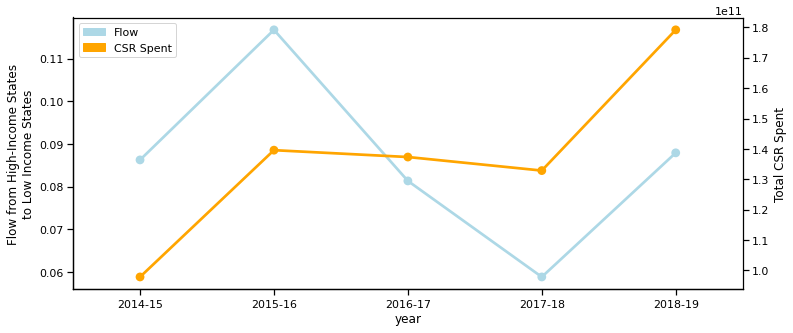

In [24]:
x=gdp_current[(gdp_current.year=="2018-19")]
x=x.merge(population, left_on="State\\UT", right_on="State")
x["gdp per capita"]=(x["gdp"]/x["population"])*10000000

rich_states = list(x[(x["gdp per capita"]>150000) & (x["population"]>10000000)]["State\\UT"])

poor_states= list(x[(x["gdp per capita"]<150000) & (x["population"]>10000000)]["State\\UT"])


flow=master_data[(master_data.State_project.isin(poor_states)) & (master_data.State_company.isin(rich_states))]
i=flow

flow=flow.groupby(["year", "State_project"])["Amount Spent"].agg("sum")
flow=flow.reset_index()

flow=flow.merge(population, left_on="State_project", right_on="State")
flow["Amount Spent pc"]=flow["Amount Spent"]/flow["population"]

flow=flow.groupby("year")["Amount Spent"].agg("sum")

#
total=master_data[master_data["State_company"].isin(rich_states)]
total=total.groupby("year")["Amount Spent"].agg("sum")

flow=flow/total


fig, ax=plt.subplots(figsize=(12,5))
ax=sns.pointplot(y=flow.values, x=flow.index, label="Flow", color="lightblue")#
sns.despine(left=False, bottom=False, right=True)

ax.set_ylabel("Flow from High-Income States\nto Low Income States")

#Total CSR Spent
data=master_data[["CIN_Number", "Amount Spent", "year" ]]
data= data.drop_duplicates()
data= data.groupby("year")["Amount Spent"].agg("sum")
data

data=master_data[["CIN_Number", "Amount Spent", "year" ]]
data= data.drop_duplicates()
data= data.groupby("year")["Amount Spent"].agg("sum")
data

ax1 = ax.twinx()
ax1.set_ylabel("Total CSR Spent")
sns.pointplot(x=data.index,y=data.values, ax=ax1, color="orange", label="CSR Spent", legend=True)


red_patch = mpatches.Patch(color='lightblue', label="Flow")
black_patch = mpatches.Patch(color='orange', label="CSR Spent")
plt.legend(handles=[red_patch, black_patch])

plt.show()

<AxesSubplot:xlabel='Average Net Profit'>

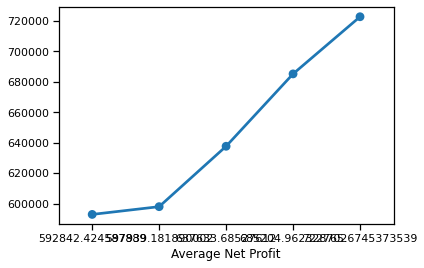

In [45]:
data=master_data[["CIN_Number", "Average Net Profit", "year" ]]
data= data.drop_duplicates()
data= data.groupby("year")["Average Net Profit"].agg("sum")
data

sns.pointplot(data=data, x=data.index, y=data.values)
#master_data

In [17]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0.2),  # blue  with alpha = 20%
})

### Andhra Pradesh & Odisha

<AxesSubplot:xlabel='year', ylabel='Amount Spent per capita'>

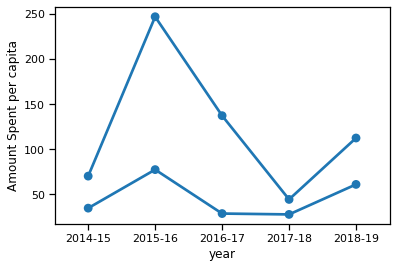

In [18]:
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.groupby(["State_project", "year"])[ "Amount Spent"].agg("sum")
#data=data.groupby("State_project").agg("mean").sort_values(ascending=False)

data=data.reset_index()
data=pd.DataFrame(data).merge(population, left_on="State_project", right_on="State")
data=data[data["population"]>10000000]

data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]
nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=nonlocal_spent[~ nonlocal_spent["State"].isin(["DELHI","GOA", "LAKSHADWEEP"])]

nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

ap_data=nonlocal_spent[ nonlocal_spent["State"].isin(["ANDHRA PRADESH"])].sort_values("year")
odisha_data= nonlocal_spent[ nonlocal_spent["State"].isin(["ODISHA"])].sort_values("year")

sns.pointplot(data=ap_data, x="year", y="Amount Spent per capita")
sns.pointplot(data=odisha_data, x="year", y="Amount Spent per capita")


In [19]:
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]
data=data[data["State_project"]=="TAMIL NADU"]

data = data[data["State_project"] != data["State_company"]]
data=data[data["Amount Spent"]!=0]
data=data.groupby("CIN_Number")["Amount Spent"].agg("sum").sort_values(ascending=False)

data[0:5].sum()/data.sum()

0.3590387001324879

In [20]:
master_data[(master_data["State_project"]=="ANDHRA PRADESH") & (master_data["year"]=="2018-19")].groupby(["year", "State_company"])["Amount Spent"].agg("sum").sort_values(ascending=False)

year     State_company     
2018-19  WEST BENGAL           2.392586e+09
         MAHARASHTRA           1.232514e+09
         TELANGANA             1.055559e+09
         ANDHRA PRADESH        8.544085e+08
         DELHI                 3.873556e+08
         TAMIL NADU            2.408251e+08
         KARNATAKA             2.024801e+08
         HARYANA               1.697600e+07
         ASSAM                 1.658200e+07
         JHARKHAND             7.744418e+06
         PUNJAB                5.249000e+06
         GUJARAT               4.005500e+06
         CHHATTISGARH          2.994000e+06
         ODISHA                2.525391e+06
         DADAR NAGAR HAVELI    2.500000e+06
         HIMACHAL PRADESH      1.756200e+06
         DAMAN & DIU           1.141001e+06
         CHANDIGARH            1.000000e+06
         KERALA                7.570200e+05
         RAJASTHAN             7.050000e+05
         MADHYA PRADESH        5.000000e+04
         UTTAR PRADESH         0.000000e+00
Name

In [21]:
master_data[(master_data["State_project"]=="UTTARAKHAND") & (master_data["year"]=="2018-19")].groupby(["year", "State_company"])["Amount Spent"].agg("sum").sort_values(ascending=False)

year     State_company   
2018-19  MAHARASHTRA         6.495602e+08
         DELHI               6.079582e+08
         UTTARAKHAND         2.064261e+08
         HIMACHAL PRADESH    5.072800e+07
         WEST BENGAL         4.339180e+07
         KARNATAKA           4.307711e+07
         PUNJAB              4.181617e+07
         TAMIL NADU          2.840300e+07
         HARYANA             2.442500e+07
         ANDHRA PRADESH      1.076400e+07
         UTTAR PRADESH       7.978172e+06
         GUJARAT             6.694493e+06
         DAMAN & DIU         4.635000e+06
         RAJASTHAN           3.123000e+06
         TELANGANA           1.445000e+06
         MADHYA PRADESH      1.000000e+06
         ASSAM               7.480000e+05
         CHHATTISGARH        5.000000e+05
         CHANDIGARH          5.000000e+05
         JHARKHAND           5.000000e+04
Name: Amount Spent, dtype: float64

In [22]:
master_data

,CSR Project(s),Project Amount Outlay,Amount Spent,year,Development Sector(s),State_project,District_project,Mode of Implementation,company name,CIN_Number,Average Net Profit,CSR Prescribed Expenditure,CSR Spent,Local Area Spent,State_company,RoC,Class,Company Type,Sub Category,Listing Status
0,NaN,0.00,0.0,2014-15,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,NaN,SAB INDUSTRIES LIMITED,L00000CH1983PLC031318,0.00,0.148671,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
1,roof water proofing,500000.00,0.0,2014-15,Environmental Sustainability,MADHYA PRADESH,Hoshangabad,Directly,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
2,training to the poor classes of people fro emp...,800000.00,0.0,2014-15,Special Education,MADHYA PRADESH,Hoshangabad,Directly,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
3,education society,500000.00,0.0,2014-15,Education,MADHYA PRADESH,Hoshangabad,Directly,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
4,public waiting hall,500000.00,0.0,2014-15,Rural Development Projects,MADHYA PRADESH,Hoshangabad,Other Implementing Agency,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201044,S Cube Infra,200000.00,200000.0,2018-19,Rural development projects,TELANGANA,NEC/ Not mentioned,Directly by company,ASIAN INSTITUTE OF GASTROENTEROLOGY PRIVATE LI...,U99999TG1994PTC018352,97.23,1.940000,1.64,1.64,TELANGANA,RoC-Hyderabad,Private,Other than Govt.,Company limited by Shares,Unlisted
201045,Lake View Sports Foundation,4200000.00,4200000.0,2018-19,Rural development projects,TELANGANA,NEC/ Not mentioned,Directly by company,ASIAN INSTITUTE OF GASTROENTEROLOGY PRIVATE LI...,U99999TG1994PTC018352,97.23,1.940000,1.64,1.64,TELANGANA,RoC-Hyderabad,Private,Other than Govt.,Company limited by Shares,Unlisted
201046,Research for promoting health care including p...,12000000.00,12000000.0,2018-19,Rural development projects,TELANGANA,NEC/ Not mentioned,Other implementing agencies,ASIAN INSTITUTE OF GASTROENTEROLOGY PRIVATE LI...,U99999TG1994PTC018352,97.23,1.940000,1.64,1.64,TELANGANA,RoC-Hyderabad,Private,Other than Govt.,Company limited by Shares,Unlisted
201047,Contribution to Akshaya Patra,1207000.00,1207000.0,2018-19,"Poverty, Eradicating Hunger, Malnutrition",TELANGANA,NEC/ Not mentioned,By Trusts/Societies/Section 8 company set up b...,ECIL-RAPISCAN LIMITED,U99999TG1995PLC019129,0.00,0.120000,0.12,0.00,TELANGANA,RoC-Hyderabad,Public,Other than Govt.,Company limited by shares,Unlisted
